In [1]:
from customdataset import CustomDataset
from SSD import *
from train_step import *
from eval_step import test_step
import os
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import time
import warnings 
warnings.filterwarnings('ignore')

In [2]:
PATH=os.getenv("HOME")+"/aiffel/ECG_data/physionet.org/files/circor-heart-sound/1.0.3/training_data"
file_list = os.listdir(PATH)
txt_list = [os.path.join(PATH, file) for file in file_list if file.endswith(".txt")]

# 환자 아이디를 훈련, 검증, 테스트 데이터셋으로 나눔
train_patient_txt, extra_patient_txt = train_test_split(txt_list, test_size=0.4, random_state=42)
valid_patient_txt, test_patient_txt = train_test_split(extra_patient_txt, test_size=0.5, random_state=42)

print(len(txt_list) ,len(train_patient_txt),
      len(valid_patient_txt) ,len(test_patient_txt)
     )

942 565 188 189


In [3]:
SAMPLE_RATE = 8000  
HOP_LENGTH = int(math.ceil(SAMPLE_RATE*0.01))#시간
WIN_LENGTH = int(math.ceil(SAMPLE_RATE / 15))#주파수
_length = WIN_LENGTH - 1

n=0
while _length > 1:
    _length = _length // 2
    n+=1
N_FFT = 2 ** (n+1)
N_MELS = 128 if N_FFT // 2 + 1 > 300 else N_FFT // 2 + 1# 20 ~ 128


In [4]:
filters = [
    (0, 400, 4000, 1.0),
    (1, 25, 4000, 1.0),
    (2, 125, 4000, 1.0),
    (3, 125, 4000, 1.0),
    (4, 125, 4000, 1.0, 1.0),
    (5, 200, 4000, 1.0, 1.0),
    (6, 125, 4000, 1.0, 1.0)
]

In [5]:
print(test_patient_txt[0]) 

/aiffel/aiffel/ECG_data/physionet.org/files/circor-heart-sound/1.0.3/training_data/50649.txt


In [6]:
def my_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 화상 gt
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt

    imgs = torch.stack(imgs, dim=0)
    return imgs, targets
BATCHSIZE = 8

In [7]:
SAMPLE_RATE = 8000
HOP_LENGTH = int(np.ceil(SAMPLE_RATE*0.01))#시간
WIN_LENGTH = int(np.ceil(SAMPLE_RATE / 15))#주파수
_length = WIN_LENGTH - 1

n=0
while _length > 1:
    _length = _length // 2
    n+=1
N_FFT = 2 ** (n+1)
N_MELS = 128 #300 if N_FFT // 2 + 1 > 300 else N_FFT // 2 + 1

print(SAMPLE_RATE, HOP_LENGTH, WIN_LENGTH, N_FFT, N_MELS)

8000 80 534 1024 128


In [8]:

s_t=time.time()

dataset = CustomDataset(PATH, train_patient_txt,
                        sample_rate=SAMPLE_RATE,
                        hop_length=HOP_LENGTH,
                        n_mels=N_MELS,
                        n_fft=N_FFT,
                        win_length=WIN_LENGTH,
                        filter_params = [filters[1], filters[0]], 
                        padding_type=0, clipping=True, 
                        target_size=(300, 300), th=5)
train_dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True, collate_fn=my_collate_fn)
e_t=time.time()

print(e_t-s_t)

105.52516388893127


In [9]:
s_t=time.time()
dataset = CustomDataset(PATH, valid_patient_txt,
                        sample_rate=SAMPLE_RATE,
                        hop_length=HOP_LENGTH,
                        n_mels=N_MELS,
                        n_fft=N_FFT,
                        win_length=WIN_LENGTH,
                        filter_params = [filters[1], filters[0]], 
                        padding_type=0, clipping=True, 
                        target_size=(300, 300), th=5)
valid_dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True, collate_fn=my_collate_fn)
e_t=time.time()

print(e_t-s_t)

37.70264983177185


In [8]:
s_t=time.time()
dataset = CustomDataset(PATH, test_patient_txt,
                        sample_rate=SAMPLE_RATE,
                        hop_length=HOP_LENGTH,
                        n_mels=N_MELS,
                        n_fft=N_FFT,
                        win_length=WIN_LENGTH,
                        filter_params = [filters[1], filters[0]], 
                        padding_type=0, clipping=True, 
                        target_size=(300, 300), th=5)
test_dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, collate_fn=my_collate_fn)
e_t=time.time()

print(e_t-s_t)

38.67711806297302


# train_step

In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model("Train", input_channels=1, is_freeze=False)
test_model =  build_model("Test", input_channels=1)
#model_weight_path='./objectdetection_model/ssd300_weight_100.pth'
#weight = torch.load(model_weight_path)
#model.load_state_dict(weight)

In [ ]:
_optim_type = "Adam"
_lr=2e-3
_model_name = "MnetSSD"
_is_freeze = "False"

train_step(model, test_model, train_dataloader, valid_dataloader, epoch_num = 100, batchsize=BATCHSIZE,
           optim_type = _optim_type, lr = _lr, device = DEVICE, model_name = _model_name,
           is_wandb=False, is_freeze=_is_freeze)

# test_step

In [12]:
_optim_type = "Adam"
_lr = 2e-3
_model_name = "MnetSSD"
_is_freeze = "False"


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model("Test", input_channels=1)
model_weight_path='./objectdetection_model/'+f'{_model_name}_weight_18_{BATCHSIZE}_{_optim_type}_{_is_freeze}.pth'
weight = torch.load(model_weight_path)
model.load_state_dict(weight)
model.eval()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
torch.autograd.set_detect_anomaly(True)
s = time.time()
recall, precison, mAP = test_step(model, test_dataloader, device = DEVICE)
e = time.time()
print(e-s)

254/254
23.49026870727539


In [14]:
print(recall, precison, mAP)

0.8196509949807245 0.7668587096868478 0.7108747772877317


<Figure size 1440x1440 with 0 Axes>

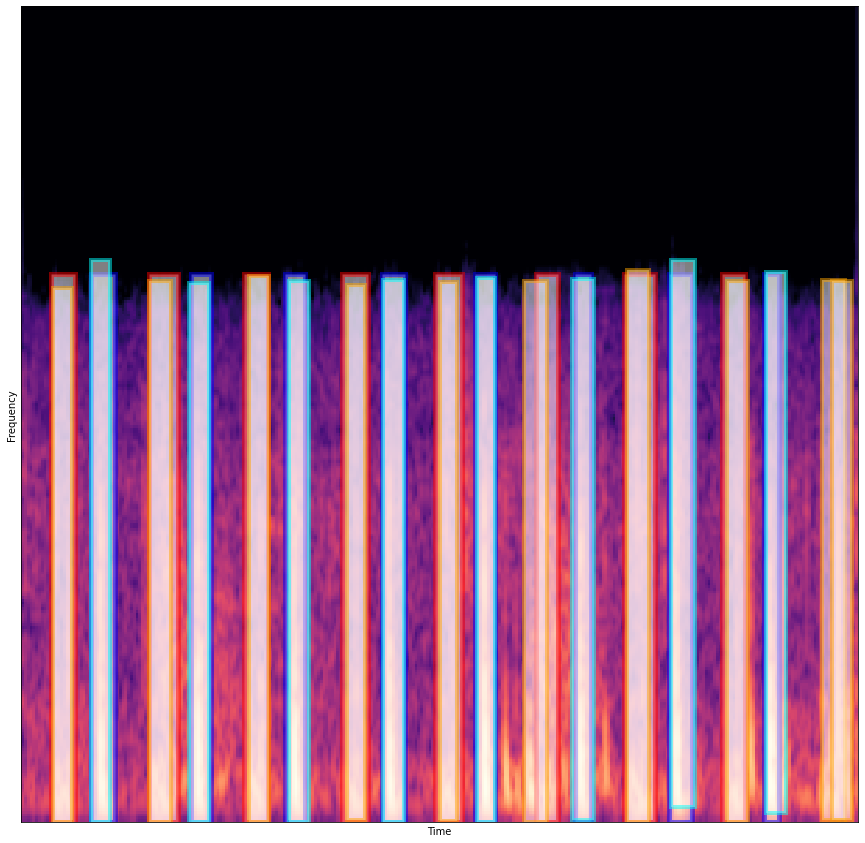

<Figure size 1440x1440 with 0 Axes>

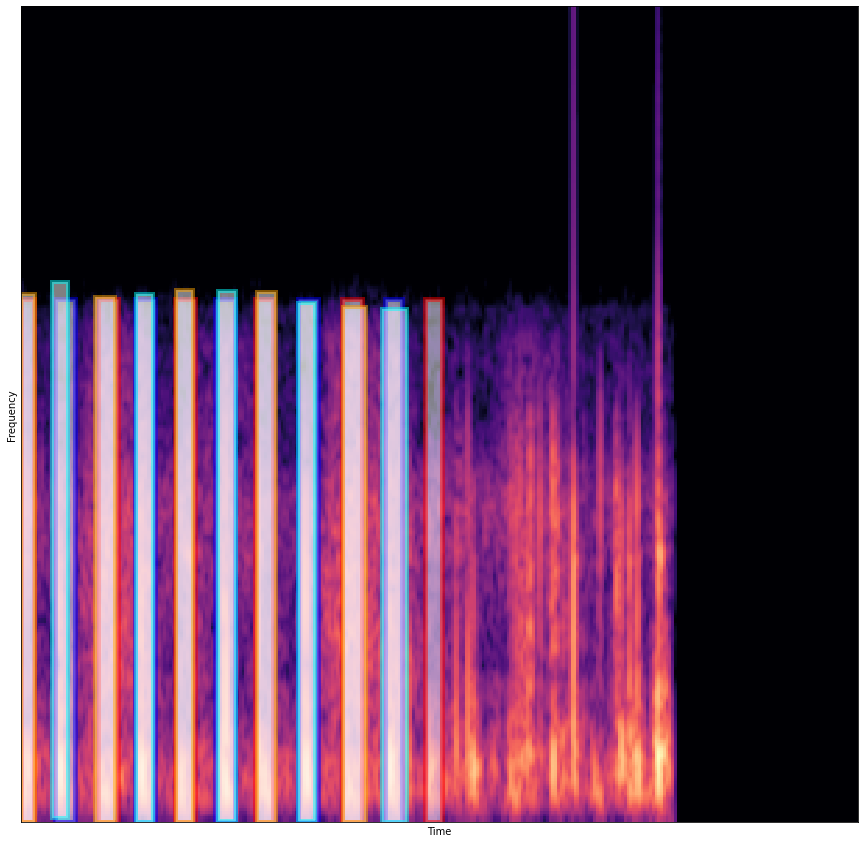

<Figure size 1440x1440 with 0 Axes>

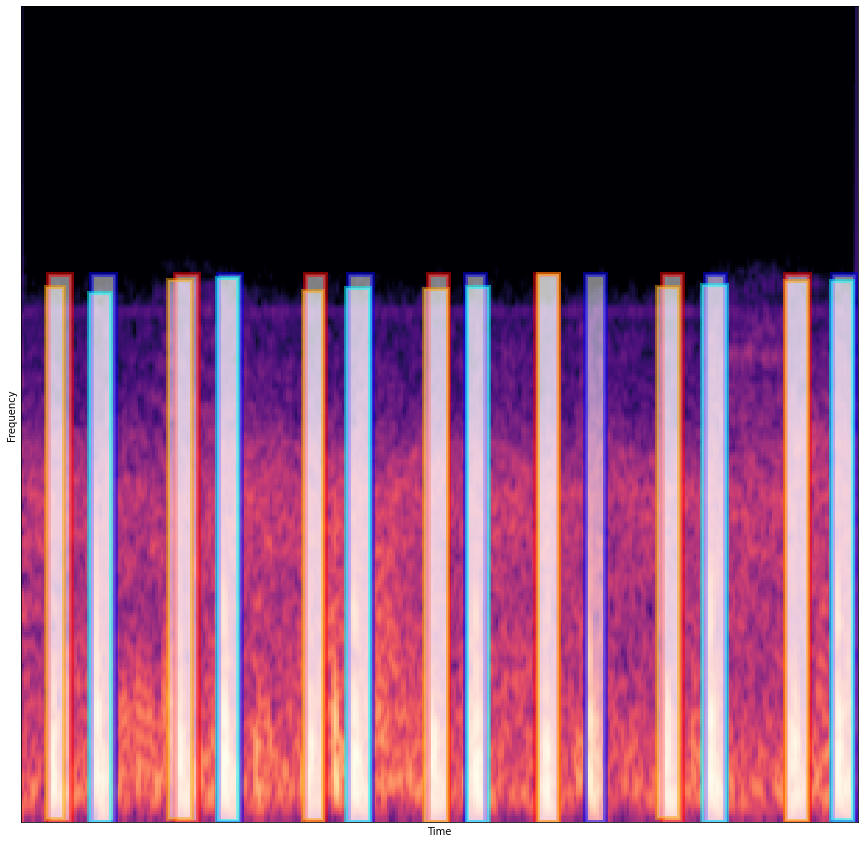

<Figure size 1440x1440 with 0 Axes>

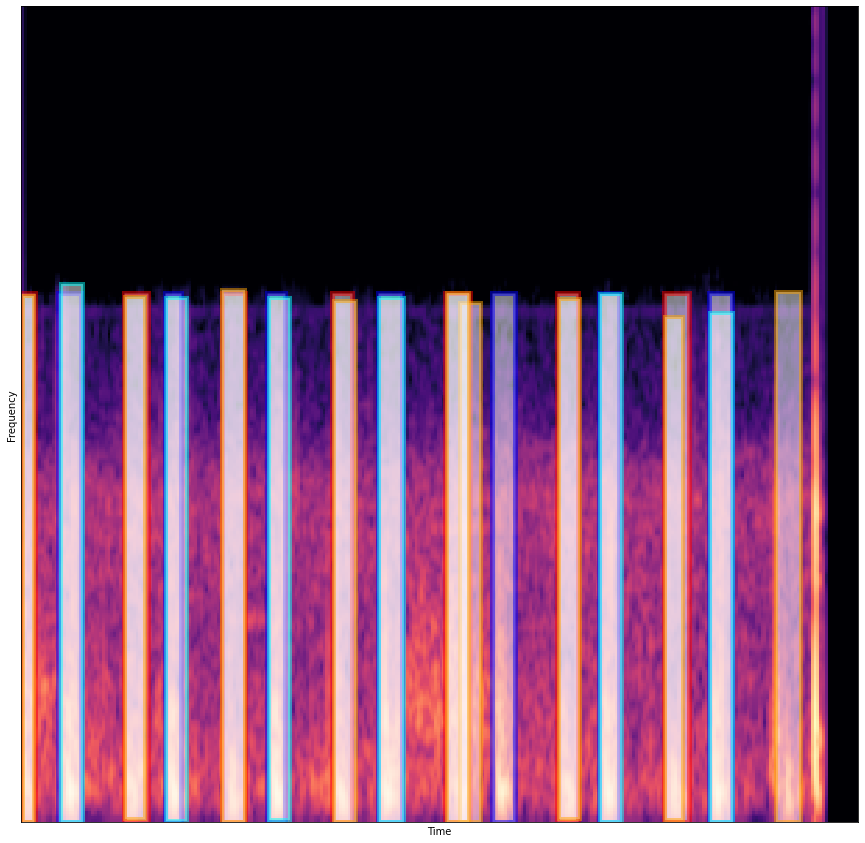

<Figure size 1440x1440 with 0 Axes>

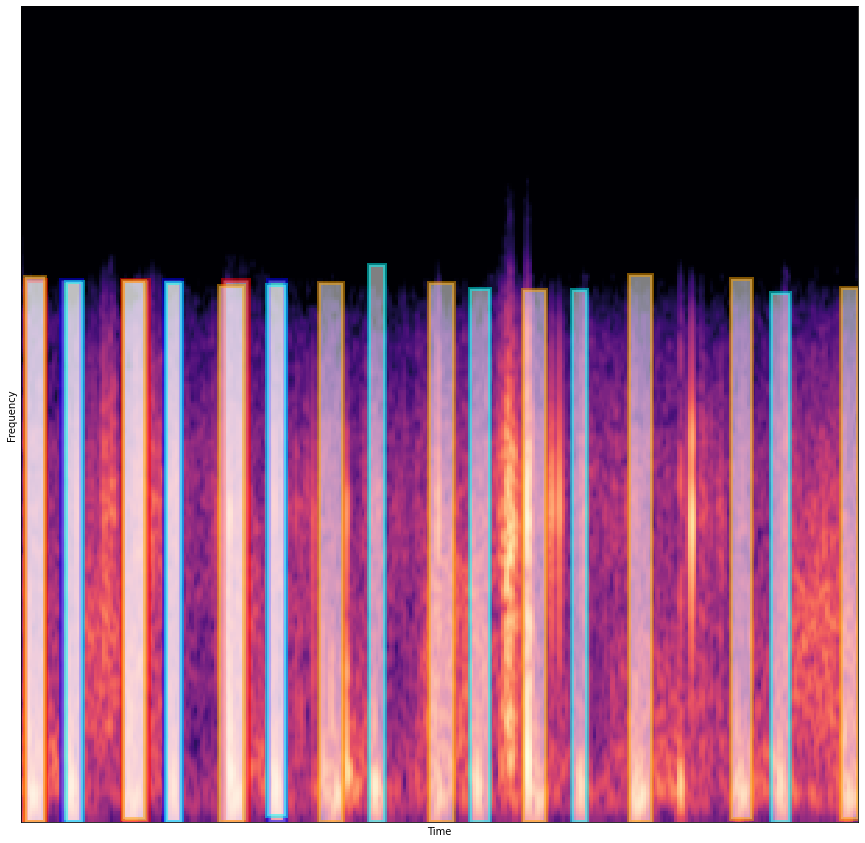

<Figure size 1440x1440 with 0 Axes>

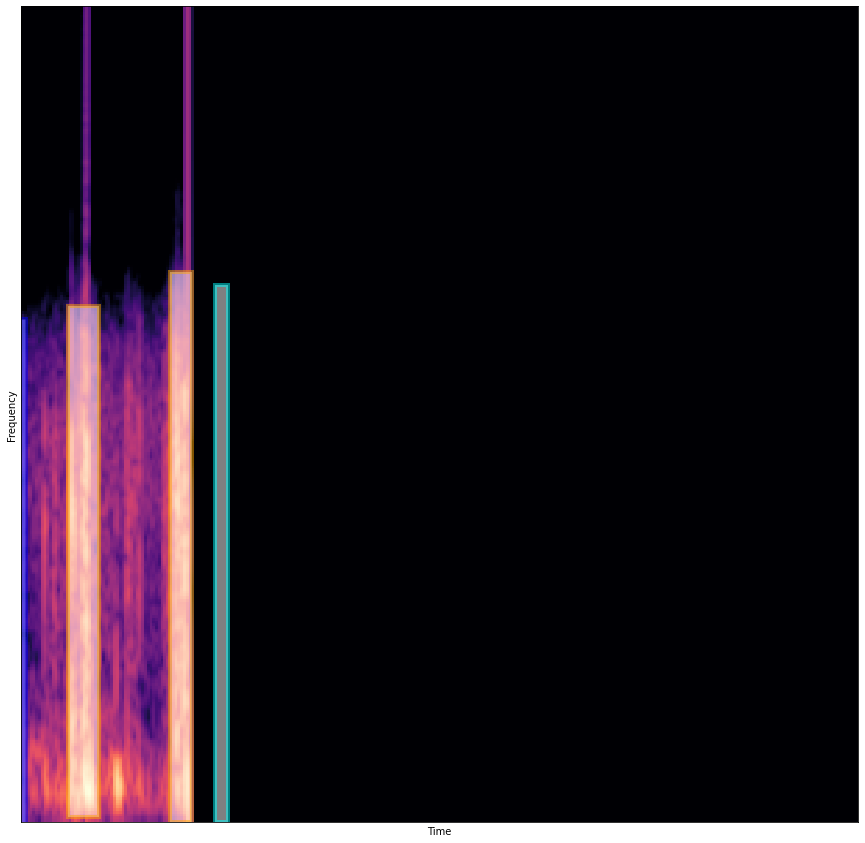

<Figure size 1440x1440 with 0 Axes>

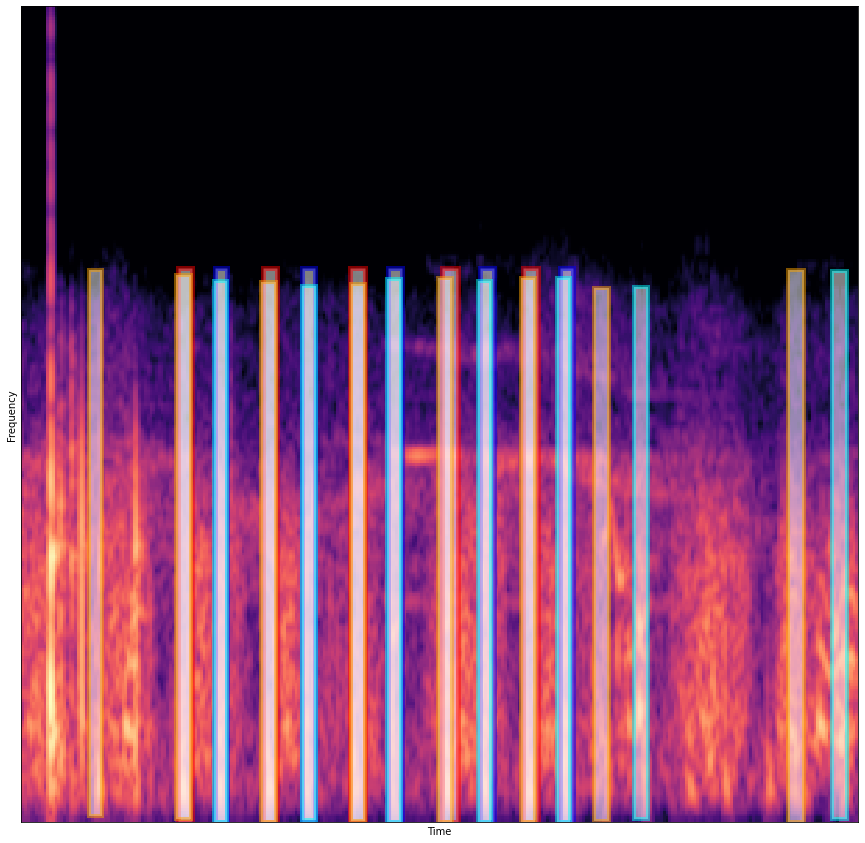

<Figure size 1440x1440 with 0 Axes>

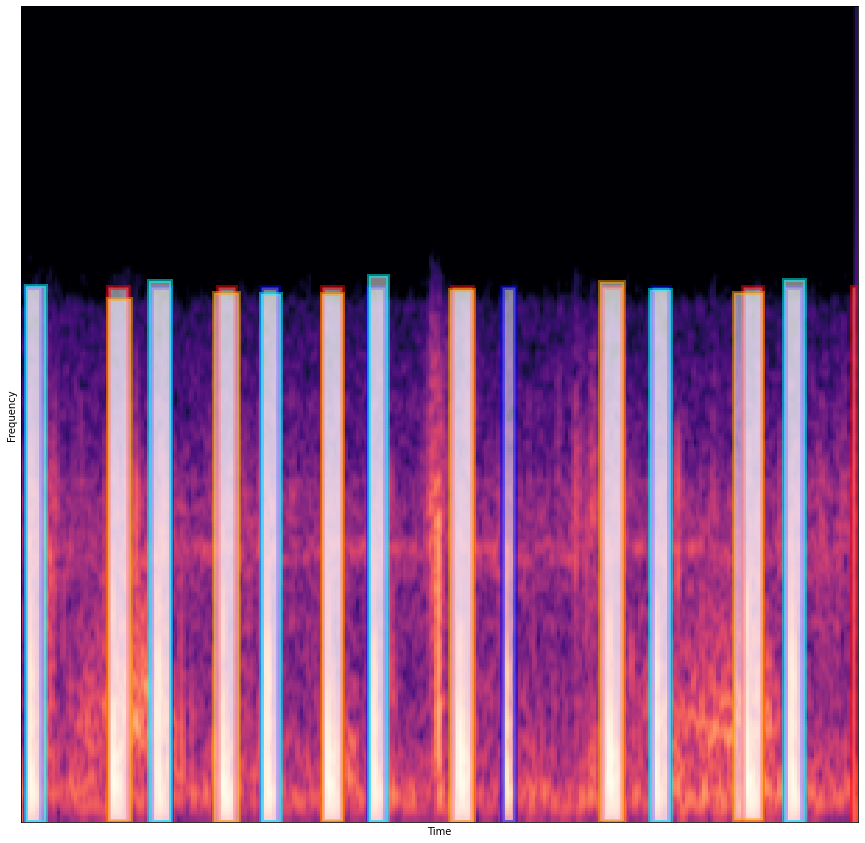

<Figure size 1440x1440 with 0 Axes>

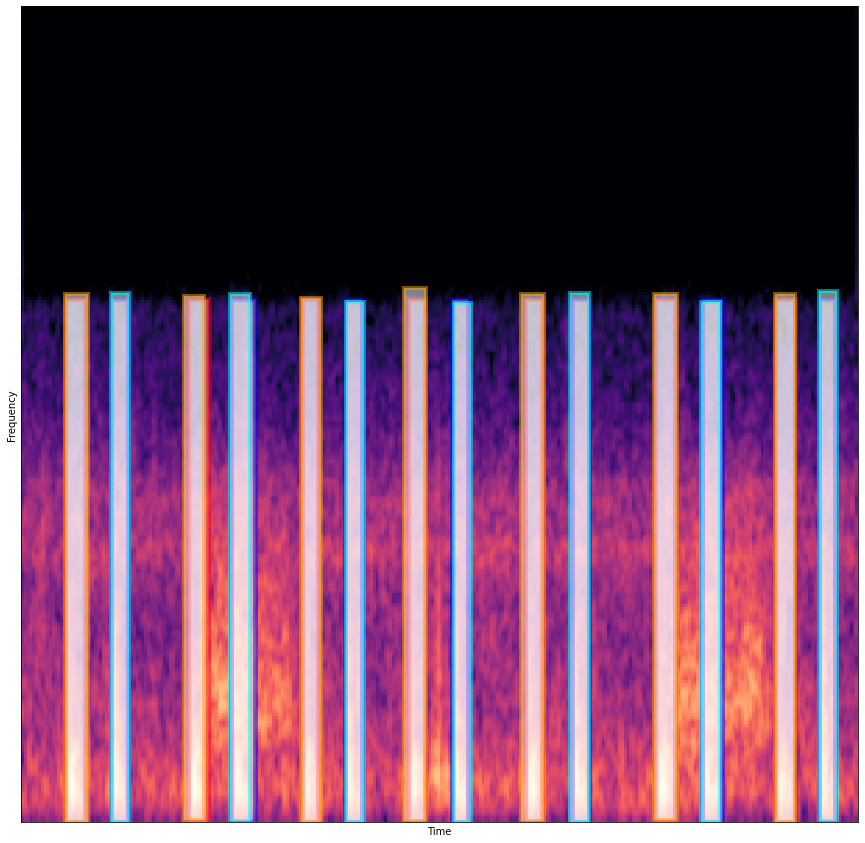

<Figure size 1440x1440 with 0 Axes>

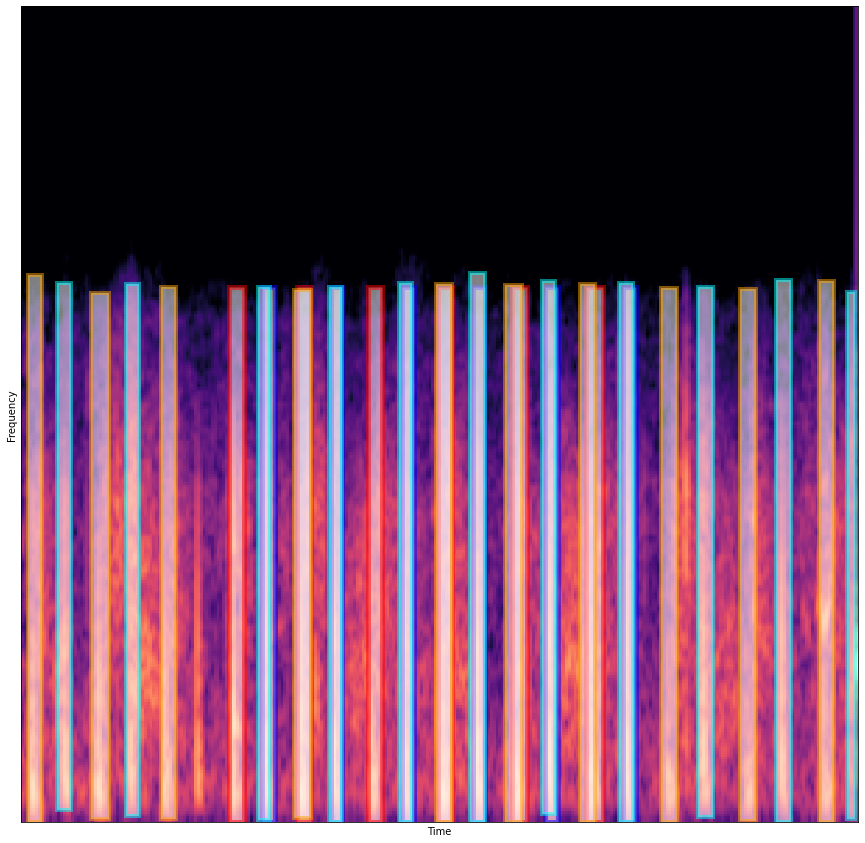

In [16]:
visualization_step(model, test_dataloader, device = DEVICE)

In [7]:
!pip freeze | grep -E "torch" >> requirements.txt
!pip freeze | grep -E "skimage" >> requirements.txt
!pip freeze | grep -E "numpy" >> requirements.txt
!pip freeze | grep -E "librosa" >> requirements.txt
!pip freeze | grep -E "wandb" >> requirements.txt
!pip freeze | grep -E "scipy" >> requirements.txt
!pip freeze | grep -E "time" >> requirements.txt
!pip freeze | grep -E "pandas" >> requirements.txt
!pip freeze | grep -E "matplotlib" >> requirements.txt

In [7]:
!pip freeze | grep -E "numpy" >> requirements.txt

In [5]:
a= True
len(a)

TypeError: object of type 'bool' has no len()

In [12]:
get_iou([0.4612,  0.0190,  0.4789,  0.9799],[0.4560,  0.0110,  0.4729,  1.0045])



0.49843741340822983

In [3]:
import torch
import torch.nn as nn
import math
from models.efficientnet import EfficientNet
from models.bifpn import BIFPN
from .retinahead import RetinaHead
from models.module import RegressionModel, ClassificationModel, Anchors, ClipBoxes, BBoxTransform
from torchvision.ops import nms
from .losses import FocalLoss


MODEL_MAP = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}


class EfficientDet(nn.Module):
    def __init__(self,
                 num_classes,
                 network='efficientdet-d0',
                 D_bifpn=3,
                 W_bifpn=88,
                 D_class=3,
                 is_training=True,
                 threshold=0.01,
                 iou_threshold=0.5):
        super(EfficientDet, self).__init__()
        self.backbone = EfficientNet.from_pretrained(MODEL_MAP[network])
        self.is_training = is_training
        self.neck = BIFPN(in_channels=self.backbone.get_list_features()[-5:],
                          out_channels=W_bifpn,
                          stack=D_bifpn,
                          num_outs=5)
        self.bbox_head = RetinaHead(num_classes=num_classes,
                                    in_channels=W_bifpn)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        self.freeze_bn()
        self.criterion = FocalLoss()

    def forward(self, inputs):
        if self.is_training:
            inputs, annotations = inputs
        else:
            inputs = inputs
        x = self.extract_feat(inputs)
        outs = self.bbox_head(x)
        classification = torch.cat([out for out in outs[0]], dim=1)
        regression = torch.cat([out for out in outs[1]], dim=1)
        anchors = self.anchors(inputs)
        if self.is_training:
            return self.criterion(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, inputs)
            scores = torch.max(classification, dim=2, keepdim=True)[0]
            scores_over_thresh = (scores > self.threshold)[0, :, 0]

            if scores_over_thresh.sum() == 0:
                print('No boxes to NMS')
                return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]
            classification = classification[:, scores_over_thresh, :]
            transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
            scores = scores[:, scores_over_thresh, :]
            anchors_nms_idx = nms(
                transformed_anchors[0, :, :], scores[0, :, 0], iou_threshold=self.iou_threshold)
            nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(
                dim=1)
            return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]

    def freeze_bn(self):
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def extract_feat(self, img):
        x = self.backbone(img)
        x = self.neck(x[-5:])
        return x

ModuleNotFoundError: No module named 'models'